In [1]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

#### Functions ####
def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return round(dataframe.iloc[-1] / dataframe.iloc[0] - 1, 4) * 100

def compute_performance_table(dataframe, years='si', freq='days'):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=False,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches()) 
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

def calendarize(returns):
    
    '''
    The calendarize function is an slight adaption of ranaroussi's monthly-returns-heatmap 
    You can find it here: https://github.com/ranaroussi/monthly-returns-heatmap/
    
    It turns monthly data into a 12 columns(months) and yearly row seaborn heatmap
    '''
    
    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plotly_table(df, width=990, height=500, columnwidth=[25], title=None , index=True, header=True,
                 header_alignment=['center'],  header_line_color='rgb(100, 100, 100)', header_font_size=[12],
                 header_font_color=['rgb(45, 45, 45)'], header_fill_color=['rgb(200, 200, 200)'],
                 cells_alignment=['center'], cells_line_color=['rgb(200, 200, 200)'], cells_font_size=[11], 
                 cells_font_color=['rgb(45, 45, 45)'], cells_fill_color=['rgb(245, 245, 245)','white' ]):
    
    # Making the header bold and conditional  
        if (header == False and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header.pop(0)
            header =  [[]] + header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
              
        # Making the header bold and conditional  
        if (header == True and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [['']] + header
            
            # Making the index Bold
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == False and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [[]] + header
            
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == True and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
        
        if title == None:
            layout = go.Layout(
                autosize=False,
                height=height,
                width=width,
                margin=go.Margin( l=0, r=0, b=0, t=0, pad=0),
            )
        else:
                layout = go.Layout(
                    autosize=False,
                    height=height,
                    width=width,
                    title=title,
                    margin=go.Margin( l=0, r=0, b=0, t=25, pad=0),
                )

        data = [trace]
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, show_link=False, config={'modeBarButtonsToRemove': ['sendDataToCloud','hoverCompareCartesian'],
                                               'displayModeBar': False})

def compute_portfolio(quotes, weights):
    
    # Anos do Portfolio
    Years = quotes.index.year.unique()

    # Dicionário com Dataframes anuais das cotações dos quotes
    Years_dict = {}
    k = 0

    for Year in Years:
        # Dynamically create key
        key = Year
        # Calculate value
        value = quotes.loc[str(Year)]
        # Insert in dictionary
        Years_dict[key] = value
        # Counter
        k += 1

    # Dicionário com Dataframes anuais das cotações dos quotes
    Quotes_dict = {}
    Portfolio_dict = {}

    k = 0    
    
    for Year in Years:
        
        n = 0
        
        #Setting Portfolio to be a Global Variable
        global Portfolio
        
        # Dynamically create key
        key = Year

        # Calculate value
        if (Year-1) in Years:
            value = Years_dict[Year].append(Years_dict[Year-1].iloc[[-1]]).sort_index()
        else:
            value = Years_dict[Year].append(Years_dict[Year].iloc[[-1]]).sort_index()

        # Set beginning value to 100
        value = (value / value.iloc[0]) * 100
        # 
        for column in value.columns:
            value[column] = value[column] * weights[n]
            n +=1
        
        # Get Returns
        Returns = value.pct_change()
        # Calculating Portfolio Value
        value['Portfolio'] = value.sum(axis=1)

        # Creating Weights_EOP empty DataFrame
        Weights_EOP = pd.DataFrame()
        # Calculating End Of Period weights
        for Name in Nomes:
            Weights_EOP[Name] = value[Name] / value['Portfolio']
        # Calculating Beginning Of Period weights
        Weights_BOP = Weights_EOP.shift(periods=1)

        # Calculatins Portfolio Value
        Portfolio = pd.DataFrame(Weights_BOP.multiply(Returns).sum(axis=1))
        Portfolio.columns=['Simple']
        # Transformar os simple returns em log returns 
        Portfolio['Log'] = np.log(Portfolio['Simple'] + 1)
        # Cumsum() dos log returns para obter o preço do Portfolio 
        Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        Portfolio['Price'] = Portfolio['Price']   

        # Insert in dictionaries
        Quotes_dict[key] = value
        Portfolio_dict[key] = Portfolio
        # Counter
        k += 1

    # Making an empty Dataframe for Porfolio data
    Portfolio = pd.DataFrame()

    for Year in Years:
        Portfolio = pd.concat([Portfolio, Portfolio_dict[Year]['Log']])

    # Delete repeated index values in Portfolio    
    Portfolio.drop_duplicates(keep='last')

    # Naming the column of log returns 'Log'
    Portfolio.columns= ['Log']

    # Cumsum() dos log returns para obter o preço do Portfolio 
    Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        
    # Round Portfolio to 2 decimals and eliminate returns
    Portfolio = pd.DataFrame(round(Portfolio['Price'], 2))

    # Naming the column of Portfolio as 'Portfolio'
    Portfolio.columns= ['Porfolio']

    return Portfolio
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_drawdowns_i(dataframe):
    '''
    Function to compute drawdowns based on 
    the inicial value of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / 100 -1) * 100
        
def print_title(string):
    display(Markdown('**' + string + '**'))
    
def all_percent(df):
    for column in df.columns:
        df[column] = df[column].apply( lambda x : str(x) + '%')
        return df

def preview(df):
    return pd.concat([fundos.head(3), fundos.tail(3)])

dimensions=(990, 500)

colorz = ['royalblue', 'orange', 'dimgrey', 'darkorchid']

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### print color.BOLD + 'Hello World !' + color.END

def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day < 0:
        day = - day
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years ' + str(month) + ' Months ' + str(day) + ' Days')

def compute_time_series(dataframe):
	(np.exp(np.log1p(dataframe).cumsum())) * 100

##################################################
### Begin of compute_drawdowns_table function ####
##################################################

### Função auxiliar 1
def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day == 0:
        day = - day
        
    if day < 0:
        month =  month - 1
        if timestamp_1.month not in [1, 3, 5, 7, 8, 10, 12]:
            day = 31 + day
        else:
            day = 30 + day        
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years, ' + str(month) + ' Months, ' + str(day) + ' Days')

### Função auxiliar 2
def compute_drawdowns_periods(df):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdown_periods = list()

    for i in range(0, len(df.index)):
      
        drawdown_periods.append(compute_time_period(df.index[i], df.index[i - 1]))
    
    drawdown_periods = pd.DataFrame(drawdown_periods)
    
    return (drawdown_periods)


### Função auxiliar 3
def compute_max_drawdown_in_period(prices, timestamp_1, timestamp_2):
    
    df = prices[timestamp_1:timestamp_2]
    
    max_dd = compute_max_DD(df)
    
    return max_dd

### Função auxiliar 4
def compute_drawdowns_min(df, prices):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdowns_min = list()

    for i in range(0, len(df.index) - 1):
      
        drawdowns_min.append(compute_max_drawdown_in_period(prices, df.index[i], df.index[i + 1]))
    
    drawdowns_min = pd.DataFrame(drawdowns_min)
    
    return(drawdowns_min)

### Função principal
def compute_drawdowns_table(prices, number=5):

    # input: df of prices
    dd = compute_drawdowns(prices)
    
    max_points = dd[dd == 0].dropna()
        
    data = [0.0] 
  
    # Create the pandas DataFrame
    new_data = pd.DataFrame(data, columns = ['New_data'])

    new_data['Date'] = prices.index.max()

    new_data.set_index('Date', inplace=True)

    max_points = pd.DataFrame(pd.concat([max_points, new_data], axis=1).iloc[:, 0])
    
    dp = compute_drawdowns_periods(max_points)
        
    dp.set_index(max_points.index, inplace=True)
    
    df = pd.concat([max_points, dp], axis=1)
    
    df.index.name = 'Date'
    
    df.reset_index(inplace=True)
    
    df['End'] = df['Date'].shift(-1)
    
    df[0] = df[0].shift(-1)
    
    df['values'] = round(compute_drawdowns_min(max_points, prices), 2)
    
    df = df.sort_values(by='values')
    
    df['Number'] = range(1, len(df) + 1)
    
    df.reset_index(inplace=True)
    
    df.columns = [['index', 'Begin', 'point', 'Length', 'End', 'Depth', 'Number']]
    
    df = df[['Begin', 'End', 'Depth', 'Length']].head(number)
    
    df.iloc[:, 2] = df.iloc[:, 2].apply( lambda x : str(x) + '%')
    
    df.set_index(np.arange(1, number + 1), inplace=True)
               
    for index, row in df['End'].iterrows():
        
        if ( (row[0] == prices.index.max())):# & (prices.iloc[-1][0] < prices.max()) ):
            
            df.iloc[index-1, 1] = float('NaN')

    return(df)

################################################
### End of compute_drawdowns_table function ####
################################################

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

# Making Color Palette
Palette = ['rgb(255, 153, 51)',     # 1 - orange
            'royalblue',            # 2 - Royalblue
            '#708090',              # 3 - Grey
            'rgb(128, 0, 128)',     # 4 - Indigo
            'rgb(219, 64, 82)',     # 5 - Red
            'rgb(0, 128, 128)',     # 6 - Teal
            '#191970',              # 7 - Navy
            'rgb(128, 128, 0)',     # 8 - Olive
            '#00BFFF',              # 9 - Water Blue
            'rgb(128, 177, 211)']   # 10 - 

[<img style="float: right;" src="https://www.futureproof.pt/files/f_photos/f_shares/logo-future-proof_smaller.png" alt="FP" border="0">](https://www.futureproof.pt/)

In [2]:
# Downloading funds and creating quotes and returns dataframes
Begin = '2000-03-10'
# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

Tickers = ['IWDA.AS' , 'IQQ0.XETRA']

Nomes = ['IWDA' , 'IQQ0']

ETFs = pd.DataFrame()

# Download
for ticker in Tickers:
    url = "https://eodhistoricaldata.com/api/eod/" + str(ticker) + "?api_token=5c982bff80deb2.22427269&period=d."
    ETF = pd.read_csv(url, index_col = 'Date', parse_dates = True)[['Adjusted_close']].iloc[:-1, :]
    ETFs = ETFs.merge(ETF, left_index = True, right_index = True, how='outer')
    
ETFs.columns = Tickers
ETFs = ETFs.fillna(method='ffill')
ETFs = ETFs.replace(to_replace=0, method='ffill')

ETFs = ETFs.loc['2000-07-07':]

In [3]:
fundos = ETFs.copy()

fundos.columns = Nomes
fundos = fundos.dropna()

fundos.index = pd.to_datetime(fundos.index)

In [7]:
#### Normalization to 100 ####
fundos = round((fundos / fundos.iloc[0] * 100), 2)

# Comparação entre IWDA/SWDA e IQQ0/MVOL

- [iShares Core MSCI World UCITS ETF USD (Acc) (EUR) | IWDA - IE00B4L5Y983 ](http://www.morningstar.es/es/etf/snapshot/snapshot.aspx?id=0P0000MLIH) - ETF tracker do MSCI World. 
- [iShares Edge MSCI World Minimum Volatility UCITS ETF USD (Acc) (EUR) | IQQ0](http://www.morningstar.es/es/etf/snapshot/snapshot.aspx?id=0P0000Y2A1) - ETF tracker do MSCI World Minimum Volatility

Segundo o <a href="https://www.blackrock.com/lu/intermediaries/literature/kiid/kiid-ishares-edge-msci-world-minimum-volatility-ucits-etf-usd-acc-gb-ie00b8fhgs14-en.pdf" target="_blank">KIID do iShares minimum volatility</a>:

*The benchmark index aims to reflect the performance characteristics of a subset of securities within the MSCI World Index (“Parent Index”) with the lowest absolute volatility of returns, subject to risk diversification. The constituents of the benchmark index are selected using a minimum volatility strategy which selects securities from the Parent Index based on estimates of the risk profile and expected volatility of each constituent and the correlation between all constituents in the Parent Index. Volatility of returns measures the movements in the daily price of the constituents over a period of time.*

A ideia do minimum volatility tem por base o uso de <a href="https://www.investopedia.com/terms/s/smart-beta.asp" target="_blank">Smart Beta</a>, neste caso uma ["anomalia"](https://en.wikipedia.org/wiki/Low-volatility_anomaly) bastante estudada quer nos <a href="https://tinyurl.com/y6anpgsd" target="_blank">serviços financeiros</a> quer em <a href="https://etf.dws.com/en-LU/EmeaAssetDownload/Index/8f1c0395-57ac-4a22-819b-94328e6b108f/Passive-Insights-1-Smart-Beta-Building-Low-Volatility-Portfolios-of-ETFs.pdf" target="_blank">termos académicos</a> que as acções com baixa volatilidade não demonstram ter, necessariamente, retornos inferiores ao resto do mercado.

Chamo a atenção também para este interessante artigo: <a href="https://www.robeco.com/en/insights/2010/ten-things-you-should-know-about-minimum-volatility-investing.html" target="_blank">Ten things you should know about minimum volatility investing</a>.

Nem tudo é necessariamente cor-de-rosa e devemos também ter uma visão crítica, onde muitas vezes somos relembrados que **"Rentabilidade passada não é garantia de rentabilidade futura"**. Neste artigo do públicado no blog do CFA institute denominado <a href="https://blogs.cfainstitute.org/investor/2018/10/29/the-dark-side-of-low-volatility-stocks/" target="_blank">The Dark Side of Low-Volatility Stocks</a> o autor tem como conclusão *"Declining interest rates likely explain most of the low-volatility strategy’s attractive risk-adjusted returns [...] Low-volatility stocks were great for risk reduction over the last few decades, protecting capital during equity market downturns. But the long US bond bull market may have run its course, and if bond and equity markets correct simultaneously, low-volatility stocks may not provide so safe a haven."*

Nos últimos anos têm de facto aparecido uma grande quantidade de ETFs dedicado a Smart Beta/Factor Investing. À medida que esses ETFs começam a ter alguns anos de comercialização começados a ter dados concretos da sua performance, ao invés de backtests teóricos.

Abaixo podemos ver a comparação directa entre um ETF que segue o MSCI World "normal" e outro o MSCI World Minimum Volatility. A análise começa desde o início de comercialização do IQQ0/MVOL a 2013-02-12. Esta comparação corrobora, de facto, que o Minimum Volatility teve de facto algumas vantagens em termos históricos, nomeadamente mais baixos drawdowns, sendo isso mais evidente em períodos de maior queda, como o final de 2018.

Como seria de esperar em períodos de subida a performance do IWDA é superior, mas teve normalmente que recuperar de uma base inferior devido à sua maior queda. Embora neste momento o IQQ0/MVOL esteja com overperformance absoluta nada nos faz pensar que assim vai continuar. Já em 2016 tinha apresentado uma grande overperformance que acabou por ser corrigida/compensada entre a segunda metade de 2016 e a primeira metade de 2017.

In [8]:
Begin = str(fundos.iloc[0].name)[0:10]

In [9]:
print_title('Cotação mais recente aquando da análise')

ETFs.tail(1)

**Cotação mais recente aquando da análise**

,IWDA.AS,IQQ0.XETRA
Date,,
2020-04-09,48.66,43.34


In [10]:
print_title('Valores finais dos fundos tendo começado em ' + Begin + ' com 100 euros')
fundos.tail(1)

**Valores finais dos fundos tendo começado em 2013-02-12 com 100 euros**

,IWDA,IQQ0
Date,,
2020-04-09,199.3,221.92


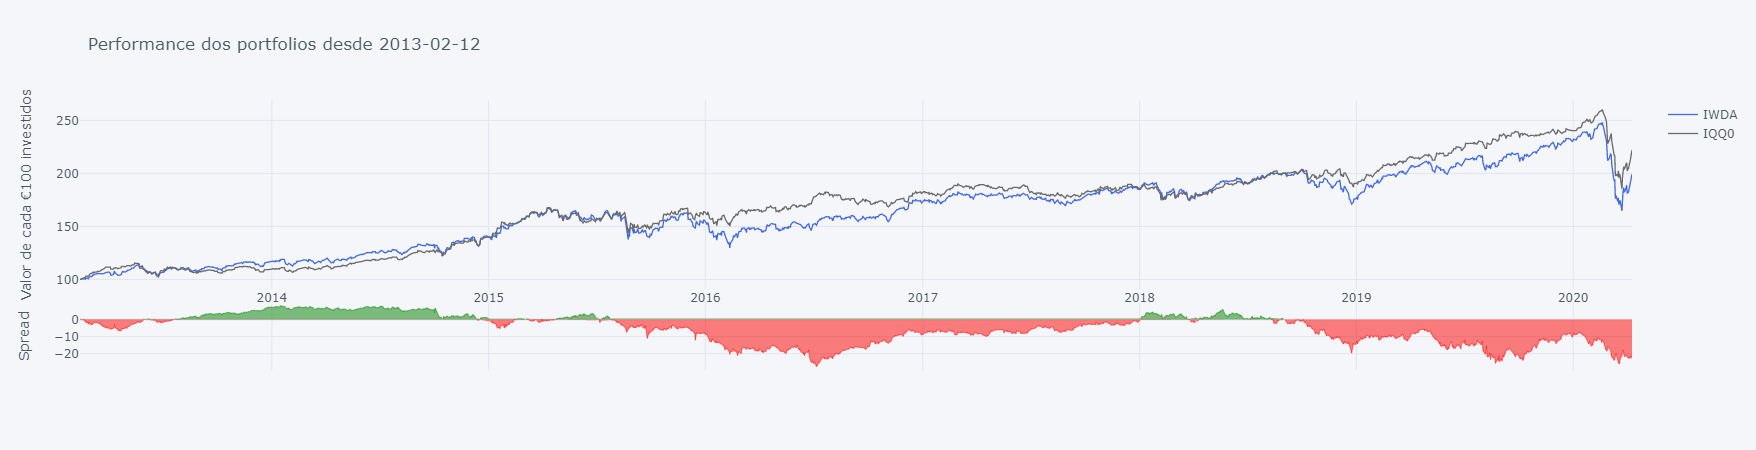

In [11]:
# Making Color Palette
Palette = ['rgb(255, 153, 51)',     # 1 - orange
            'royalblue',            # 2 - Royalblue
            '#708090',              # 3 - Grey
            'rgb(128, 0, 128)',     # 4 - Indigo
            'rgb(219, 64, 82)',     # 5 - Red
            'rgb(0, 128, 128)',     # 6 - Teal
            '#191970',              # 7 - Navy
            'rgb(128, 128, 0)',     # 8 - Olive
            '#00BFFF',              # 9 - Water Blue
            'rgb(128, 177, 211)']   # 10 - 

fundos.iplot(title='Performance dos portfolios desde ' + Begin, yTitle='Valor de cada €100 investidos', color=['royalblue', 'dimgrey'], kind='spread')

O gráfico acima apresenta a linha de performance de ambos os ETFs. Em baixo podemos ver um pequeno gráfico do diferencial absoluto entre ambos e nos apercebermos facilmente das diferentes performances ao longo do tempo. Podemos observar uma overperformance do IQQ0 em períodos de stress dos mercados accionistas que acaba por ser compensada por uma underperformance quando os mercados estão a subir.

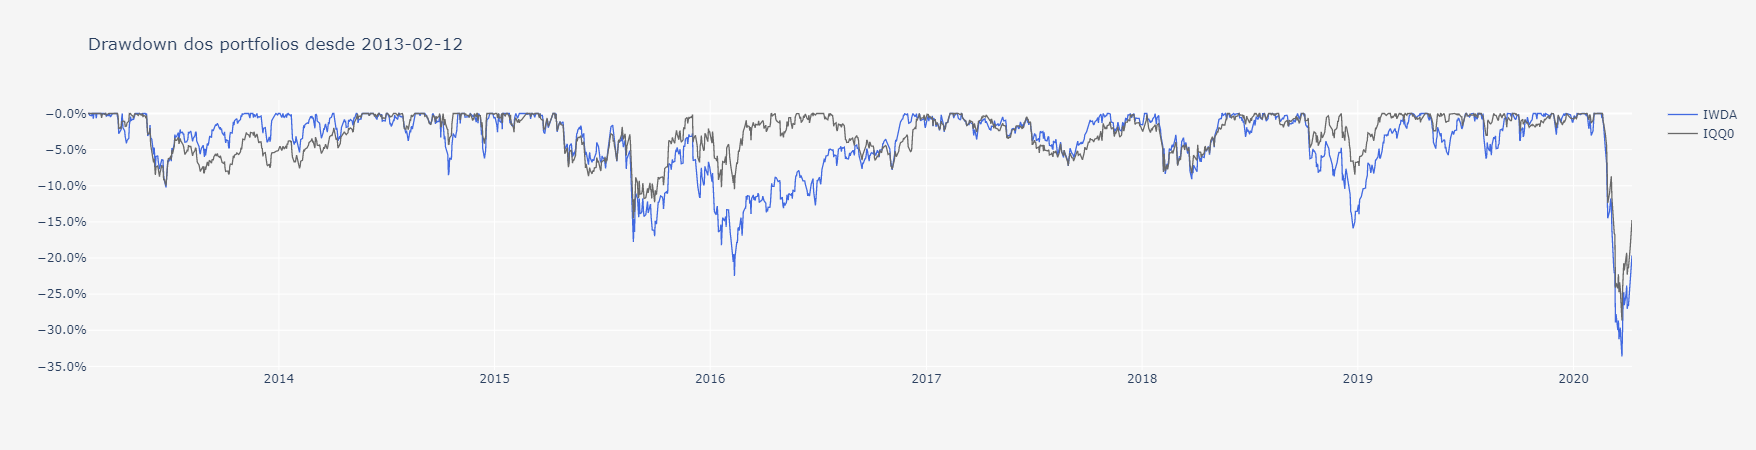

In [12]:
DD = compute_drawdowns(fundos)
DD = DD /100

layout = go.Layout(
    title='Drawdown dos portfolios desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    xaxis=dict(
        title='',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%" # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 0],
    name = 'IWDA',
    line = dict(
        color = 'royalblue',
        width = 1.3)
)

trace1 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 1],
    name = 'IQQ0',
    line = dict(
        color = 'dimgrey',
        width = 1.3)
)

data = [trace0, trace1]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

No gráfico acima podemos visualizar os drawdowns de ambos os ETFs. Reparamos que para drawdowns pequenos (abaixo de 10%) as quedas são semelhantes, mas em momentos extremos em que os drawdowns chegam aos dois dígitos é onde o IQQ0 demonstra as suas vantagens. Podemos ver isso na quebra do início de 2016 onde o IWDA teve uma quebra de 22.5% face aos máximos enquanto o IQQ0 apenas 10.5%. Isso repete-se de forma muito semelhante na queda do último trimestre de 2018.

In [13]:
print_title('Drawdown actual (' + str(DD.index[-1])[0:10] + ')')
DD = compute_drawdowns(fundos)
DD = DD /100
DD.tail(1).applymap(lambda x: "{0:.2f}%".format(x*100))

**Drawdown actual (2020-04-09)**

,IWDA,IQQ0
Date,,
2020-04-09,-19.66%,-14.75%


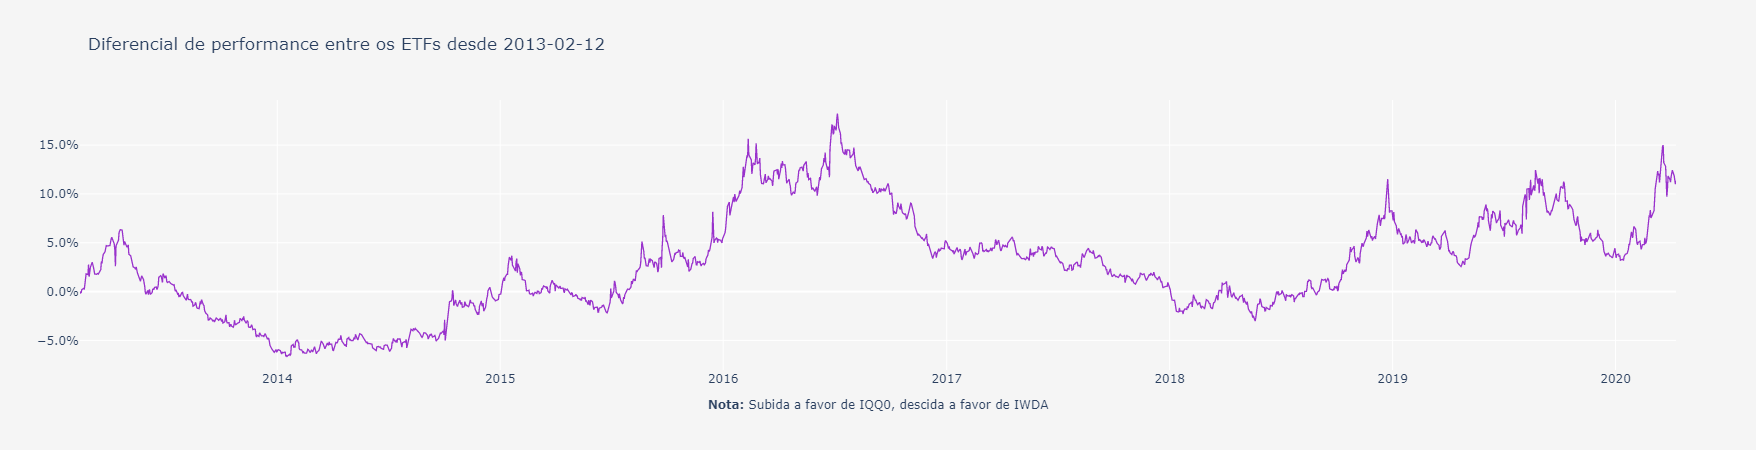

In [14]:
layout = go.Layout(
    title='Diferencial de performance entre os ETFs desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    xaxis=dict(
        title='<b>Nota:</b> Subida a favor de IQQ0, descida a favor de IWDA',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%" # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = fundos.index,
    y = (round(((fundos.iloc[:, 1] / fundos.iloc[:, 0])- 1), 5)),
    name = 'Portfolio',
    line = dict(
        color = 'darkorchid',
        width = 1.3)
)

data = [trace0]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Este gráfico apresenta a diferença relativa (ao invés da absoluta) entre ambos os ETFs. Como já vimos acima a maior diferença entre os ETFs aconteceu no início de 2016, devido a uma grande diferença na dimensão do drawdown. Isso foi normalizado entre meados de 2016 e início de 2018.

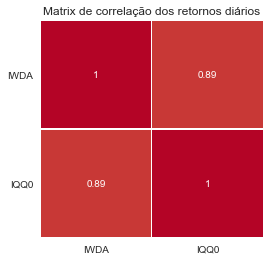

In [15]:
# #### Returns ####
returns = (fundos / fundos.shift(1)) - 1

# Correlation Matrix
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", linewidths=.2, vmin = -1, cbar=False)
plt.yticks(rotation=360)
plt.title('Matrix de correlação dos retornos diários')
plt.show()

In [16]:
print_title('Performance dos fundos desde ' + Begin)
compute_performance_table(fundos)

**Performance dos fundos desde 2013-02-12**

,CAGR,StdDev,Sharpe,Max DD,MAR
IWDA,10.11%,15.86%,0.64,-33.63%,0.30
IQQ0,11.77%,13.19%,0.89,-28.65%,0.41


In [17]:
print_title('Performance a 12 meses')
fundos_1 = filter_by_date(fundos, years=1)
compute_performance_table(fundos_1)

**Performance a 12 meses**

,CAGR,StdDev,Sharpe,Max DD,MAR
IWDA,-3.13%,22.72%,-0.14,-33.63%,-0.09
IQQ0,3.67%,19.39%,0.19,-28.65%,0.13


In [18]:
print_title('Performance a 3 anos')
fundos_3 = filter_by_date(fundos, years=3)
compute_performance_table(fundos_3)

**Performance a 3 anos**

,CAGR,StdDev,Sharpe,Max DD,MAR
IWDA,3.24%,16.52%,0.20,-33.63%,0.10
IQQ0,5.44%,13.89%,0.39,-28.65%,0.19


In [19]:
print_title('Performance a 5 anos')
fundos_5 = filter_by_date(fundos, years=5)
compute_performance_table(fundos_5)

**Performance a 5 anos**

,CAGR,StdDev,Sharpe,Max DD,MAR
IWDA,3.87%,17.08%,0.23,-33.63%,0.11
IQQ0,6.00%,14.29%,0.42,-28.65%,0.21


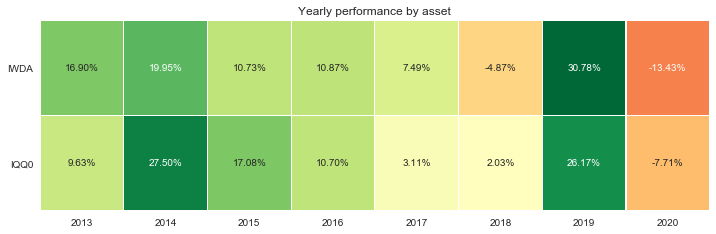

In [20]:
fundos_norm = fundos.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(12,3.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance by asset')
plt.show()

In [21]:
print_title('Drawdown Table de ' + fundos.iloc[:, 0].name)
compute_drawdowns_table(fundos.iloc[:, 0])

**Drawdown Table de IWDA**

,Begin,End,Depth,Length
1,2020-02-19,NaT,-33.63%,"0 Years, 1 Months, 21 Days"
2,2015-04-15,2016-11-30,-22.49%,"1 Years, 7 Months, 15 Days"
3,2018-10-03,2019-04-01,-15.9%,"0 Years, 5 Months, 29 Days"
4,2013-05-22,2013-10-31,-10.23%,"0 Years, 5 Months, 9 Days"
5,2018-01-23,2018-05-17,-9.1%,"0 Years, 3 Months, 24 Days"


In [22]:
print_title('Drawdown Table de ' + fundos.iloc[:, 1].name)
compute_drawdowns_table(fundos.iloc[:, 1])

**Drawdown Table de IQQ0**

,Begin,End,Depth,Length
1,2020-02-19,NaT,-28.65%,"0 Years, 1 Months, 21 Days"
2,2015-04-13,2016-04-14,-14.52%,"1 Years, 0 Months, 1 Days"
3,2013-05-15,2014-05-22,-9.97%,"1 Years, 0 Months, 7 Days"
4,2018-12-04,2019-02-11,-8.47%,"0 Years, 2 Months, 7 Days"
5,2017-03-01,2018-05-25,-8.29%,"1 Years, 2 Months, 24 Days"


Outra grande diferença entre o IQQ0 e o MSCI World também pode ser vista aqui. Enquanto o IWDA apenas teve um drawdown de grande extensão (neste caso 1 ano e 7 meses) o IQQ0 apresenta dois drawdowns de alguma extensão, um de um ano e outro de 1 ano e 2 meses. Ou seja, embora historicamente menos profundos o IQQ0 não é estranho a drawdowns com períodos superiores a um ano. Chamo a atenção para o facto de ele ter feito um máximo em 4 de Dezembro de 2018 e ter começado aí o drawdown de fim de 2008 ao contrário do IWDA que começou em 2018-10-03.

In [23]:
# Turning daily quotes into monthly
Portfolio_M = fundos.resample('BM').last()
# Monthly returns
Portfolio_ret_M = Portfolio_M.pct_change()

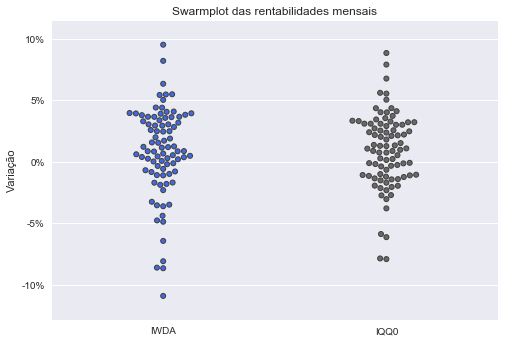

In [24]:
my_pal = ["royalblue", "dimgrey"]

ax = sns.swarmplot(data=Portfolio_ret_M, orient='v', linewidth=1,  palette=my_pal)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title("Swarmplot das rentabilidades mensais")
ax.set_xlabel('')
ax.set_ylabel('Variação')
plt.show()

Este gráfico apresenta um ponto por cada rentabilidade mensal. Podemos ver o quanto os valores negativos extremos são inferiores no IQQ0, com as duas piores rentabilidades a rondar os -6%, enquanto no IWDA ultrapassam os -8%. Podemos ver no quadro abaixo em que meses isso aconteceu.

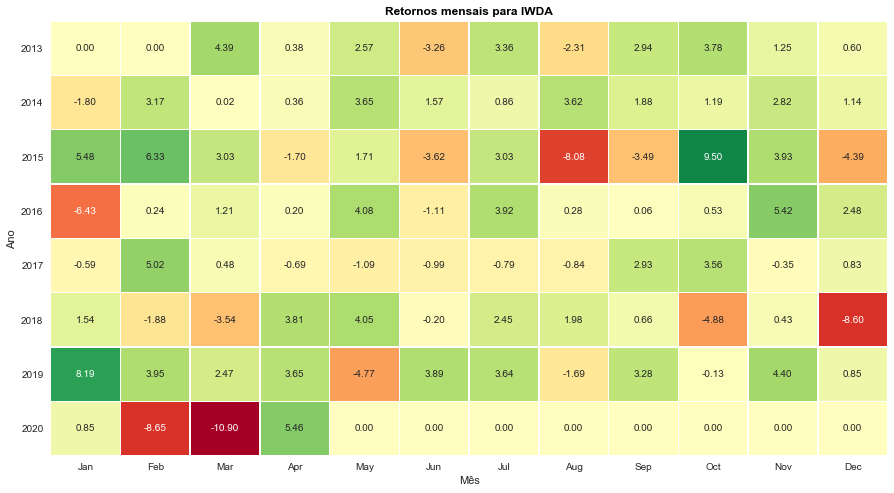

In [25]:
# Compute monthly returns table
nr = 0

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, 8))

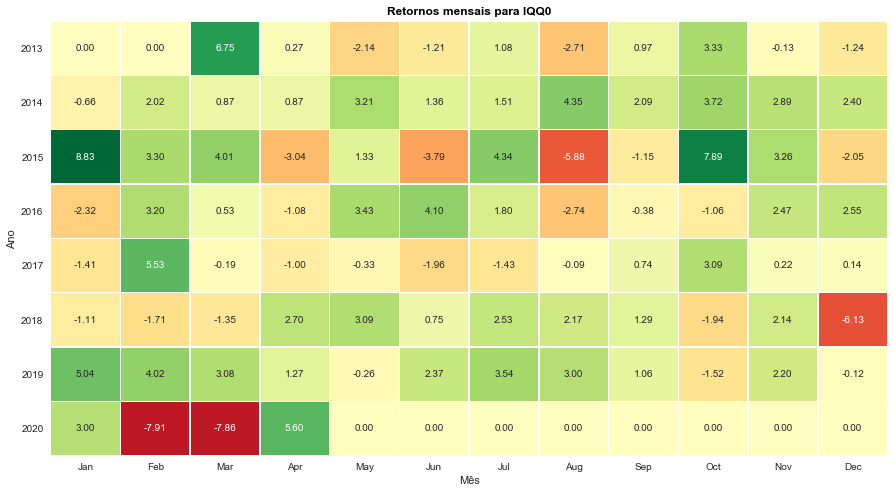

In [26]:
# Compute monthly returns table
nr = 1

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, 8))

In [27]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF